# Explainer Notebook

## 1. Motivation

Our dataset consists of animal pages on Wikipedia, where we used web scraping methods and the WikiData API to collect a dataset. We choose this particular dataset because when looking at Wikipedia in general there is always a link to another page within a wikipedia page and then another link. This we thought would be interesting to look at in regards to the kingdom of animals. Because some groups of animals are more likely to mention each other in a wikipedia article. We first analyzed all of the approximately 30k wikipedia pages and then narrowed down our network to only reptiles in order to narrow down the dataset. 

This dataset was somewhat inspired by the Wikipedia Game, which is getting from one wikipedia page to a totally different one in the fewest amount of moves. However for it to be feasible we only look at k = 1 depth, as the amount of website requests would skyrocket with k > 1. We therefore wanted to see how the different wikipedia pages for animals were connected.
Our goal with the analysis of our Wikipedia animal dataset was to show the user and viewer how connected these animals actually are on wikipedia.

The network could be seen as a tool to win the wikipedia game for the user. Because you have all the connections and can hereby assess what website would be optimal to enter. 

## 2. Basic stats

The data that will be used in the analysis, has been gathered by using the WikiData API using their query builder. Due to the Wikipedia pages not having a category called “Animals” that allows you to gather all the animal pages, we will use an alternative which is querying on the Wikidata pages that have a “Animal Diversity Website (ADW) taxon id”. The query to gather the data is:

In [ ]:
query = '''
    SELECT DISTINCT ?item ?itemLabel WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
      {
        SELECT DISTINCT ?item WHERE {
          ?item p:P4024 ?statement0.
          ?statement0 (ps:P4024) _:anyValueP4024.
        }
      }
    }
    '''
query_reptile = '''
    SELECT DISTINCT ?item ?itemLabel WHERE {
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
      {
        SELECT DISTINCT ?item WHERE {
          ?item p:P4024 ?statement0.
          ?statement0 (ps:P4024) _:anyValueP4024.
          ?item p:P5473 ?statement1.
          ?statement1 (ps:P5473) _:anyValueP5473.
        }
      }
    }
    '''

In [ ]:
from tqdm import tqdm
import requests
import json
from bs4 import BeautifulSoup
import re
from get_links import links_on_page
import networkx as nx
import matplotlib.pyplot as plt
from netwulf import visualize
import pickle
import numpy as np

The first query just request all the pages where it has a Animal Diversity Website (ADW) taxon id, this query is made by their auto query builder.
The second query request all the pages where it has a Animal Diversity Website (ADW) taxon id aswell as a Reptile Database ID.

The get_wiki_links function takes n amount of wikidata ids, and in the query they are seperated with | as this allows us to query up to 50 ids at a time. We then loop over the response and check if it contains a link to an english wikipedia site.

In [ ]:
def get_wiki_links(item_ids):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={'|'.join(item_ids)}&props=sitelinks/urls&format=json&sitefilter=enwiki"
    response = requests.get(url)
    data = json.loads(response.text)
    wiki_links = []
    for item_id in item_ids:
        wikipedia_url = data["entities"][item_id]["sitelinks"]
        if "enwiki" in wikipedia_url: # only save if the page has a reference to an english wikipage
            link = wikipedia_url["enwiki"]["url"]
            wiki_links.append(link)
    return wiki_links

For the actual quering, we start by getting all the wikidata pages that fit our query (query & query_reptile). We loop over 50 pages at a time, and get their wikipedia links with get_wiki_links, and write the results to a .txt file where each entry is seperated by a new line.

In [ ]:
url = 'https://query.wikidata.org/sparql'
r = requests.get(url, params = {'format': 'json', 'query': query_reptile})
data = r.json()

data = data["results"]["bindings"]
temp = []
for entries in tqdm(range(0,len(data),50)):
    if entries+50 < len(data):
        sub_list = [ids["itemLabel"]["value"] for ids in data[entries:(entries+50)]]
        temp = temp + get_wiki_links(sub_list)
    else:
        sub_list = [ids["itemLabel"]["value"] for ids in data[entries:(len(data))]]
        temp = temp + get_wiki_links(sub_list)
file = open('animal_links_reptile.txt','w')
for item in temp:
    file.write(item+"\n")
file.close()

Now for creating our nodes and edges. We open the .txt file from before, and prepare for the web scraping:

In [ ]:
edgelist_weights = {}
edgelist_weights_long = {}
#animal_name = "Elephant"
names = names_from_table() # Gets all the entries in the larger table on https://en.wikipedia.org/wiki/List_of_animal_names
names_long = {}
with open('data/animal_links_reptile.txt', 'r') as f:
    entries = f.read().splitlines()
for name in tqdm(entries):
    name_temp = name.split("/")[-1]
    names_long[name_temp] = 0 # Saving all the entries in the txt file in a dict, for a fast comparisons (ie. only make pairs
                                #  with animals and not wikipages for unrelated stuff)
attributes_dict = {}

For each wikipedia link in the .txt file, we get all the links on the page aswell as look for infoboxes using links_on_page. This function just uses the wikipedia api to get all the information on the page in json format, and then we find all href in the wikipedia page and save these.
Then we look for a infobox, since there are 2 ways wikipedia makes these, we have to check if infobox is none, as this indicates the infobox is the other type.
Then we go through the infobox (table) and extract predefined values we wanna use as attributes.
In case there is no infobox on the page, ie. infobox is never updated from having None as values, we discard this page as it is most likely a redirect page.

In [ ]:
def links_on_page(animal_name="Elephant"):
    url = "https://en.wikipedia.org/w/api.php?action=parse&page="+animal_name+"&format=json" # we can either put the title page or the URL version
                                                                                             # of the title, ex. Malayan softshell turtle = Malayan_softshell_turtle
    response = requests.get(url)
    html = json.loads(response.content.decode('utf-8'))['parse']['text']['*'] # Default way the result comes in
    soup = BeautifulSoup(html, 'html.parser')
    links = soup.find_all('a', href=lambda href: href and href.startswith('/wiki/') and not href.endswith('.jpg') and not href.endswith('.png'))
    # ^ sometimes the links link to jpg and png file, sort them out
    result = []
    for link in links:
        href = link.get('href')
        title = link.get('title')
        text = link.text
        result.append(href)
    info = {"Class:": None, "Order:":None, "Superfamily:":None, "Family:":None,"Name:": None} # Default dict allows us to see if its redirect later
    infobox = soup.find('table', {'class': 'infobox biota biota-infobox'}) # One type of infoboxes wiki uses
    if infobox is None:
        infobox = soup.find('table', {'class': 'infobox biota'}) # Other type of infoboxes wiki uses
    if infobox:
        rows = infobox.find_all('tr') # Going through the rows in the infobox
        for row in rows:
            td = row.find_all('td')
            if td: # Checking if empty
                if td[0].text.strip() in ["Class:", "Order:", "Superfamily:", "Family:"]: # the info we want is stored in a row at a time
                                                                                          # it has two columns first being Class, Order...
                                                                                          # the other being the attributes we will save 
                    if td:
                        info[td[0].text.strip()] = td[1].text.strip() # Making the category the key, and the attribute value the value
        info["Name:"] = animal_name # Updating from default 

    return result, info

One of the graph we make is the one where we only make a edge a list of 224 animal names from https://en.wikipedia.org/wiki/List_of_animal_names, this wikipedia page contains two tables, one of them being one with the overall animal species (no subspecies).
Due to it being a wikipedia page, there is a lot of references and stuff we dont want in our scraping which is removed with re.sub, where we have given it some predefined things to remove.

In [ ]:
def names_from_table():
    url = "https://en.wikipedia.org/wiki/List_of_animal_names"
    
    response = requests.get(url)
    html_content = response.content
    
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Find table on the page
    table = soup.find_all('table',{"class":"wikitable"})[1]
    
    # Find all the rows in the table
    t_rows = table.find_all('tr')
    
    ths = t_rows[0].find_all('th')
    
    header = [th.text.replace("\n","") for th in ths]
    
    rows = []
    names = {}
    for tr in t_rows[1:]:
        tds = tr.find_all('td')
        if tds:
            links = tds[0].find_all('a')
            if links:
                row = [td.text.replace("\n","") for td in tds]
                rows.append(row)
                cleaned_row = re.sub(r'\(.*\)|Also see.*|\[\d+\]|See.*', '', row[0]) # The table is not clean, many unwanted formating we remove here
                for link in links:
                    link_href = link.get('href')
                    if link_href.startswith('/wiki/'):
                        names[link_href] = cleaned_row
                        break
    import pandas as pd
    df_animals = pd.DataFrame(rows, columns=header)

    return names

Now for the actual scraping of websites, we loop over all the entries from our .txt file. We check if its redirect by looking at if infobox is None (its default scenario) if not, we add it to our edgelist. One of them to be used for directed and the other for undirected graph.

In [ ]:
for name in tqdm(entries):
    temp_string = name.split("/")[-1]
    result, info = links_on_page(animal_name=temp_string)
    if info["Name:"] is not None: # A way to remove wiki redirects from the final result, as redirects dont have the infoboxes we want
        attributes_dict[info["Name:"]] = info # Making nested dicts to quickly get attributes later
        for entry in result:
            if entry in names: # making one graph where we only make edges to the table from https://en.wikipedia.org/wiki/List_of_animal_names
                pair = ("/wiki/"+temp_string,entry) # Making pairs to compare for the dict
                pair_inverted = (entry,"/wiki/"+temp_string)
                if pair in edgelist_weights:
                    edgelist_weights[pair] += 1 # If the pair is already in the dict, the weight is increased
                elif pair_inverted in edgelist_weights:
                    edgelist_weights[pair_inverted] += 1 # If the inverted pair is already in the dict, the weight is increased
                else:
                    edgelist_weights[pair] = 1 # If the pair is not in the dict, the weight is 1
            if entry.split("/")[-1] in names_long: # making other graph where we make edges between entries from the .txt file
                pair = (temp_string, entry.split("/")[-1]) # Only taking the last part of the URL (the URL title of the page)
                if pair in edgelist_weights_long:
                    edgelist_weights_long[pair] += 1 # If the pair is already in the dict, the weight is increased
                else:
                    edgelist_weights_long[pair] = 1 # If the pair is not in the dict, the weight is 1


In order to avoid doing this over and over we dump the results as pickle files

In [ ]:
with open('data/data_plain_reptile_test.pickle', 'wb') as fp:
    pickle.dump(edgelist_weights, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/data_plain_long_reptile_test.pickle', 'wb') as fp:
    pickle.dump(edgelist_weights_long, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/Reptile_attributes.pickle', 'wb') as fp:
    pickle.dump(attributes_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)


To visulize them, they are first loaded and then we loop over all the entries and add them to an edgelist, and construct the graph with this edgelist.
We then add all our attributes to the graph, and for sanity check we remove nodes than dont have attributes saved in our .pickle file.

In [ ]:
with open('data/all_animal_to_all_animal.pickle', 'rb') as handle:
    b = pickle.load(handle)
with open('data/animal_attributes.pickle', 'rb') as handle:
    c = pickle.load(handle)

values = list(b.values())
plt.hist(values, bins=np.arange(max(values))-0.5, edgecolor='black')
plt.yscale("log")
plt.xticks(range(1, max(values) + 1))
plt.xlabel('Number of references')
plt.ylabel('Frequency')
plt.show()

edgelist = [None]*len(b)
for i,items in enumerate(b):
    edgelist[i] = (items[0].replace("/wiki/", ""),items[1].replace("/wiki/", ""),int(b[items]))
G = nx.DiGraph()

G.add_weighted_edges_from(edgelist)
print(G)

to_remove =[]
for Names in tqdm(G.nodes):
    if Names in c:
        G.nodes[Names]['Class'], G.nodes[Names]['Order'], G.nodes[Names]['Superfamily'], G.nodes[Names]['Family'], _ = c[Names].values()
    else:
        to_remove.append(Names) # Some nodes get added to graph even though they are redirects, the cause is known but no good way to handle it
for names in to_remove:
    G.remove_node(names)
print(G)
network, config = visualize(G)

degree = []
for node in G.nodes():
    degree.append(G.degree(node))
plt.hist(degree,bins=np.arange(max(values))-0.5, edgecolor='black')
plt.title("Degree distribution")
plt.xlabel('Number of degrees')
plt.ylabel('Frequency')
plt.show()

## 3. Tools, theory and analysis

### Network Theory

##### Fraction of edges
The fraction of edges in a network is a measure that quantifies the density of edges in a network by comparing the number of edges in the network to the maximum number of edges that could be present in a network with the same number of nodes.

The fraction of edges ranges from 0 to 1, where 0 indicates an empty network with no edges, and 1 indicates a completely connected network where every pair of nodes is connected by an edge. Intermediate values indicate networks with varying levels of connectivity.

The fraction of edges is an important measure of network density and can provide insights into the organization and structure of the network. Networks with high edge density tend to have many connections between nodes, while networks with low edge density tend to have relatively few connections. The fraction of edges is also useful for comparing the connectivity of networks with different numbers of nodes.

##### Assortivity
Assortativity is a measure of the degree to which nodes in a network tend to connect to other nodes with similar attributes. So it quantifies the tendency of nodes with similar characteristics, such as degree or other node properties, to be connected to each other in the network.

The assortativity coefficient ranges from -1 to 1, where 1 indicates perfect assortativity, which means nodes are connected to other nodes with identical attributes. 0 indicates no assortativity, which means nodes are connected to other nodes randomly with respect to their attributes. And -1 indicates perfect disassortativity which means nodes are connected to other nodes with opposite attributes.

Assortativity is an important measure in network analysis because it can provide insights into the organization and structure of the network. For example, networks that exhibit high assortativity tend to have tightly connected groups of nodes that share similar characteristics, while networks with low assortativity tend to be more randomly connected.

##### Modularity
Modularity measures the structure of a network, which contains nodes and the edges(links) that connect them. Modularity is typically expressed as a number between -1 and 1. 

We used the formular below to calculate the modularity. For a full network we consider the complete partition that breaks the network into $n_c$ communities. To see if the local link density of the subgraphs defined by this partition differs from the expected density in a randomly wired network, we define the partition’s modularity by summing  over all $n_c$ communities 
$M=\sum_{c=1}^{n_c}\left[\frac{L_c}{L}-(\frac{k_c}{2L})^2\right]$ 

The higher modularity for a partition, the better is the corresponding community structure. A partition with a lower modularity clearly deviates from these communities. 

We can use the modularity to see how well the community structure of the network is.


##### Double edge swap
The double edge swap algorithm is a network optimization algorithm used to randomize the edges in a network while preserving certain topological properties. The algorithm works by iteratively swapping pairs of edges in the network, while ensuring that the degree distribution of the nodes and the total number of edges in the network remain constant.

The double edge swap algorithm is useful for generating randomized networks for use as null models in statistical analyses of real-world networks. By comparing the properties of a real network to those of its randomized counterpart, researchers can determine which properties of the real network are statistically significant and which are simply a result of chance.

In order to asses if the modularity is statistically dofferent from 0, we will use the double edge swap algorithm. Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. 

In the given network we will not run the double edge swap alogorithm due to the computational time. With networks of low density it works quite fast, but with netowrks lige the one used here, the running time is just too long. 

##### Louvain
The Louvain algorithm is a community detection algorithm used to identify the communities or groups within a network.

The algorithm works by optimizing a modularity function that measures the quality of the community structure. The modularity function quantifies the extent to which the number of edges within communities is higher than the expected number in a random network with the same degree sequence.

### Network Analysis

Opening the stored data with two helper functions, clean_family cleans the attribute values from wikipedia as these can contain symbols and extra stuff we are not interested in. The add_attr function adds the attributes to the network.

The banned set, is for cleaning up the nodes for the "cleaned" network described in https://natasha0301.github.io/Project-website/network-analysis/

Please note some of the functions used below, are either directly from previous assignments or modified to fit the problem at hand.

In [6]:
import networkx as nx
import pickle
import random
import community
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import colorsys
from netwulf import visualize
import pandas as pd


def clean_family(string):
    if string is None:
        return None
    string = string.replace("†","").replace(" (","")
    count = 0
    for i,chara in enumerate(string):
        if chara.isupper():
            count += 1
            if count > 1:
                return string[:i]
    return string

def add_attr(Graph,attr_dict):
    to_remove =[]
    for Names in Graph.nodes:
        if Names in attr_dict:
            Graph.nodes[Names]['Class'], Graph.nodes[Names]['Order'], Graph.nodes[Names]['Superfamily'], Graph.nodes[Names]['Family'], _ = attr_dict[Names].values()
            Graph.nodes[Names]['Class'] = clean_family(Graph.nodes[Names]['Class']) if Graph.nodes[Names]['Class'] is not None else None
        else:
            to_remove.append(Names) # Some nodes get added to graph even though they are redirects, the cause is known but no good way to handle it
    for names in to_remove:
        Graph.remove_node(names)
    return Graph

# Load Network
with open('data/all_animal_to_all_animal.pickle', 'rb') as handle:
    b = pickle.load(handle)
with open('data/animal_attributes.pickle', 'rb') as handle:
    c = pickle.load(handle)
banned_set = {"Animal","Reptile","Arthropod","Chordate","Bird","Rodent","Insect"}
for items in c:
    banned_set.add(clean_family(c[items]["Class:"]))
    banned_set.add(clean_family(c[items]["Order:"]))
    banned_set.add(clean_family(c[items]["Superfamily:"]))
    banned_set.add(clean_family(c[items]["Family:"]))
#edgelist = [None]*len(b)
banned_set = {} # Comment to get "cleaned" network
edgelist = []
for i,items in enumerate(b):
    if items[0] not in banned_set and items[1] not in banned_set:
        edgelist.append([items[0].replace("/wiki/", ""),items[1].replace("/wiki/", ""),int(b[items])])
G_reptile = nx.Graph()


G_reptile.add_weighted_edges_from(edgelist)
print(G_reptile)
G_reptile_attr = add_attr(G_reptile,c)

Graph with 31565 nodes and 480654 edges


Below are the functions to calculate the fraction of edges in the same class or Family. The functions are not smart, ie. have to manully change between Class and Family.

In [9]:
def same_class(G):
    same_class_fractions = []
    for node in G.nodes():
        same_class_neighbors = 0
        total_neighbors = 0
        
        for neighbor in G.neighbors(node):
            if G.nodes[neighbor]["Class"] == G.nodes[node]["Class"]:
                same_class_neighbors += 1
            total_neighbors += 1
        
        if total_neighbors > 0:
            same_field_fraction = same_class_neighbors / total_neighbors
        else:
            same_field_fraction = 0
        same_class_fractions.append(same_field_fraction)
    return same_class_fractions

def same_class_rand(Graph):
    shuffled_G = Graph.copy()
    Family = [Graph.nodes[node]["Class"] for node in Graph.nodes()]
    random.shuffle(Family)

    for i, node in enumerate(shuffled_G.nodes()):
        shuffled_G.nodes[node]["Class"] = Family[i]
    return shuffled_G

def same_class_rand_n(Graph, n = 250):
    results = []
    Family = [Graph.nodes[node]["Class"] for node in Graph.nodes()]
    for i in range(n):
        temp = same_class_rand(Graph)
        results.append(np.mean(same_class(temp)))
    plt.hist(results,label = "Random", bins = 20)
    plt.xlabel("Fraction")
    plt.ylabel("Frequency")
    plt.title("Fraction of edges in same Class")
    plt.show()

Due to the size of the network we are not able to do a random shuffles between the edges, in a timely manner (network has >500,000 edges).

In [11]:
# Same class fractions
same_class_fractions = same_class(G_reptile_attr)
print(f"The average fraction is: {np.mean(same_class_fractions):.3f}")

# Same class fractions for random graph
same_class_fractions_rand = same_class_rand(G_reptile_attr)
print(f"The average fraction for random graph is: {np.mean(same_class(same_class_fractions_rand)):.3f}")

# Same class fractions
#same_family_rand_n(G_reptile_attr, n = 250)


The average fraction is: 0.685
The average fraction for random graph is: 0.169


The result of the average fraction strongly indicates that this cannot be explained by pure chance, as the random graph uses randomly shuffled edges. Which goes hand in hand with what the underlying data is, as landbased animals have a very low chance of having something in common with sea based animals, that could cause them to get a wikipedia reference between them.

For the assortativity coefficient, we reuse function from last assignment. This metric is used to tell  how likely similar nodes are to connect to other similar nodes over dissimilar nodes. In other words it reflects the degree of homophily or heterophily in the network. 

In [12]:
def assortative_matrix(Graph,unique_labels):
    matrix = np.zeros((len(unique_labels),len(unique_labels)))

    values = nx.get_node_attributes(Graph, "Class").values()
    num_values = len(values)

    for start, end in Graph.edges(): # Looping over all edges in graph (since its undirected its not really start and stop)
        x = Graph.nodes[start]["Class"] # Getting the start point of the edge 
        y = Graph.nodes[end]["Class"] # Getting the end point of the edge 
        if x in unique_labels: 
            x = unique_labels[x]
        else:
            x = unique_labels[None] # in case x is nan
            
        if y in unique_labels:
            y = unique_labels[y]
        else:
            y = unique_labels[None] # in case y is nan
        matrix[x, y] += 1 
        
    num_edges = len(Graph.edges())
    matrix /= num_edges # averaging the occurence with the total edges

    trace = np.trace(matrix) # trace of the matrix, the sum of the diagonal entries
    mix_matrix = np.sum(np.matmul(matrix, matrix))

    r1 = (trace-mix_matrix)/(1-mix_matrix) # Eq. 2

    return r1

In [13]:
# Assortativity coefficient 
labels = np.unique([G_reptile_attr.nodes[node]["Class"] for node in G_reptile_attr.nodes() if G_reptile_attr.nodes[node]["Class"] is not None])
unique_labels = {name: i for i,name in enumerate(labels)}
unique_labels[None] = len(unique_labels)
r1 = assortative_matrix(G_reptile_attr,unique_labels)
print(f"Assortativity coefficient: {r1:.3f}")

Assortativity coefficient: 0.777


This indicates a strong connection that nodes in similar classes connect to each other rather than them from different classes. This supports the observation from the fraction of edges, where seabased animals do not have a lot in common with landbased, and so on.

The compute modularity function is unchanged from last assigment.

In [14]:
def compute_modularity(Graph,partitioning):
    L = Graph.number_of_edges() * 2 # In = Out
    M = 0
    communities = set(partitioning.values())

    for community in communities:
        nodes_in_community = [node for node, community_id in partitioning.items() if community_id == community]
        subgraph = Graph.subgraph(nodes_in_community)
        k_c = sum(dict(subgraph.degree()).values())
        L_c = subgraph.number_of_edges()
        M += L_c / L - (k_c / (2 * L)) ** 2

    return M

In [16]:
# Modularity Class split of Reptile Graph
Class_split = nx.get_node_attributes(G_reptile_attr, "Class")

#Then we compute the modularity of the partitioning by using the function above
modularity = compute_modularity(G_reptile_attr, Class_split)

print(f"The modularity of the Class split partitioning is {modularity:.3f}")

# Modularity Family split of Reptile Graph
Family_split = nx.get_node_attributes(G_reptile_attr, "Family")

#Then we compute the modularity of the partitioning by using the function above
modularity = compute_modularity(G_reptile_attr, Family_split)

print(f"The modularity of the family split partitioning is {modularity:.3f}")

The modularity of the Class split partitioning is 0.369
The modularity of the family split partitioning is 0.158


This result shows that the class split is a better representation for the community structure. When comparing the two splits visually, we observe the same behaviour. As the family split does not have the same kind of seperated clustering as the class split has.

The modularity is used to see the degree of clustering and how well the nodes can be organized into distinct communities. This measure, measures the identification of meaningful substructures within the network

Due to the size of the network it is not feasible to construct new random graphs, to determine if they are statistically different from zero, however the function to do this for smaller networks is:

In [17]:
def double_edge_swap(GG,N):
    """
    Example usage: G_new = double_edge_swap(G_reptile,len(list(G_reptile.edges())))
    """
    i = 0
    G_copy = GG.copy()
    while(i<2*N):
        edges = list(G_copy.edges()) # update edges after adding and removal
        (u, v), (x, y) = random.sample(edges, 2) # picking two random edges
        if (u != v) and (v != x) and (u, y) not in G_copy.edges() and (x, v) not in G_copy.edges(): # checking conditions
            G_copy.add_edge(u, y)
            G_copy.add_edge(x, v)
            G_copy.remove_edge(u, v)
            G_copy.remove_edge(x, y)
            i+=1
    return G_copy


We will now use the louvain community detection algoritm

In [18]:
#Louvain algorithm
partition = community.best_partition(G_reptile,random_state=42) # dictionary, keys are the nodes and values are communities for each node

# modularity of partition
modularity = community.modularity(partition, G_reptile) 

size = []
for community_ in set(partition.values()):
    temp = []
    for part in partition:
        if partition[part] == community_:
            temp.append(part)
    size.append(len(temp))

print("Number of communities:", len(set(partition.values())))
print("Community sizes:", sorted(size,reverse=True))
print(f"Modularity: {modularity:.2f}")

Number of communities: 30
Community sizes: [10084, 5832, 3353, 3051, 2868, 1204, 900, 514, 356, 332, 302, 264, 260, 258, 222, 189, 172, 169, 135, 128, 117, 117, 116, 115, 113, 110, 43, 37, 31, 1]
Modularity: 0.79


The Louvain algorithm is quite good at seperating the nodes into seperate clusters. However this suffers greatly with the amount of communities it predicts, as the communities in the original network which weren't clearly clustered, get put into one cluster.

To determine the performance we will find the accuracy aswell as construct a confusion matrix. We start by getting the partion done by Louvain, and then mapping the pred labes and true labels, as the nodes are in the same order.

We then look for where the predicted is the same as the ground truth, and use np.mean to get the accuracy.

For the confusion matrix we construct the empty array and populate it by counting the number of times (true,pred) pair occurs.

In [19]:
louvain_labels = list(partition.values())

#ground truth community labels as a list
gt_labels = [G_reptile_attr.nodes[node_id]["Class"] for node_id in G_reptile_attr.nodes()]
gt_labels = [labels if labels is not None else "None" for labels in gt_labels] # convert None to string(None)

#mapping between pred labels and ground truth labels
label_mapping = {}
for louvain_label, gt_label in zip(louvain_labels, gt_labels):
    if louvain_label not in label_mapping:
        label_mapping[louvain_label] = gt_label


louvain_labels_mapped = [label_mapping[label] for label in louvain_labels] #convert pred labels to ground truth labels

accuracy = np.mean([1 if louvain == gt else 0 for louvain, gt in zip(louvain_labels_mapped,gt_labels)])
print(f"Accuracy of Louvain: {accuracy:.3f}")

labels = sorted(set(gt_labels + louvain_labels_mapped)) #Create a sorted list of unique labels
num_classes = len(labels)

cm = np.zeros((num_classes, num_classes), dtype=int)

# Count the number of occurrences of each (true, pred) label pair
for true, pred in zip(gt_labels, louvain_labels_mapped):
    cm[labels.index(true)][labels.index(pred)] += 1

confusion_matrix_df = pd.DataFrame(cm, index=unique_labels, columns=range(num_classes))
print(confusion_matrix_df)

Accuracy of Louvain: 0.647
                 0     1    2     3    4    5    6    7    8    9    ...  96   \
Actinistia         0     4    0     0    0    0    0    0    0    0  ...    0   
Actinopterygii     0  2673    0     0    0    0    0    0    0    0  ...    0   
Allomalorhagida    0     3    0     0    0    0    0    0    0    0  ...    0   
Amphibia           0     1    0  3051    0    0    0    0    0    0  ...    0   
Anopla             0     2    0     0    0    0    0    0    0    0  ...    0   
...              ...   ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
Tubothalamea       0    30    0     0    0    0    0    0    0    0  ...    0   
Turbellaria        0     1    0     0    0    0    0    0    0    0  ...    0   
Tylenchoidea       0     2    0     0    0    0    0    0    0    0  ...    0   
Udeonychophora     0     1    0     0    0    0    0    0    0    0  ...    0   
None               0     3    0     0    0    0    0    0    0    0  ...    0   



The confusion matrix is to big to display, to see it fully it is recommended to open it with a variable explorer or exporting it to some other format. However as we see that the Louvain algorithm achieves an accuracy of 64.7% which does seem good on the surface. But when we dig into the actual numbers, the high accuracy comes mainly from the large clusters which are seperated. And everything inbetween these large clusters are not detected as being different clusters (for good reason).

To visualise the graph with different splits we create n unique colors and add a color attribute to our graph. The first uses Louvain splits and the second uses attribute splits.

In [25]:
num_communities = len(set(partition.values()))
hue_start = 0.0
saturation = 0.8
value = 0.8

colors = []
for i in range(num_communities):
    hue = hue_start + (i / num_communities)
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
    color_hex = "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255))
    colors.append(color_hex)

community_numb = list(partition.values())
for i, n in enumerate(G_reptile_attr.nodes()):
    G_reptile.nodes[n]['color'] = colors[community_numb[i]]
visualize(G_reptile)

({'xlim': [0, 946],
  'ylim': [0, 946],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 0.6,
  'links': [{'source': 'Scaly-crowned_babbler',
    'target': 'Malacopteron',
    'width': 0.3098386676965933,
    'weight': 1},
   {'source': 'Scaly-crowned_babbler',
    'target': 'Animal',
    'width': 0.3098386676965933,
    'weight': 1},
   {'source': 'Scaly-crowned_babbler',
    'target': 'Chordate',
    'width': 0.3098386676965933,
    'weight': 1},
   {'source': 'Scaly-crowned_babbler',
    'target': 'Bird',
    'width': 0.43817804600413285,
    'weight': 2},
   {'source': 'Scaly-crowned_babbler',
    'target': 'Passerine',
    'width': 0.3098386676965933,
    'weight': 1},
   {'source': 'Malacopteron',
    'target': 'Grey-breasted_babbler',
    'width': 0.3098386676965933,
    'weight': 1},
   {'source': 'Malacopteron',
    'target': 'Sooty-capped_babbler',
    'width': 0.3098386676965933,
    'weight': 1},
   {'source': 'Malacopteron'

In [24]:
config

{'zoom': 0.6,
 'node_charge': -29.78450085263414,
 'node_gravity': 0.1625104342467057,
 'link_distance': 7.887473590273367,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#79aaa0',
 'node_stroke_color': '#555555',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': False,
 'node_size': 5,
 'node_stroke_width': 1,
 'node_size_variation': 0.5,
 'link_color': '#7c7c7c',
 'link_width': 2,
 'link_alpha': 0.5,
 'link_width_variation': 0.5,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

In [ ]:
colors = []
for i in range(len(unique_labels)):
    hue = hue_start + (i / len(unique_labels))
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
    color_hex = "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255))
    colors.append(color_hex)

print(f"Amount of unique familys in dataset: {len(unique_labels):.0f}")
for i, n in enumerate(G_reptile_attr.nodes()):
    G_reptile.nodes[n]['color'] = colors[unique_labels[G_reptile_attr.nodes[n]["Class"]]]

network, config = visualize(G_reptile)

### Text Theory 
Term frequency–inverse document frequency (TF-IDF) is a numerical statistic that is used to measure the importance of a word in a text or a corpus a collection of text. It is a technique within natural language processingand text mining.

The TF-IDF score of a word is proportional to the number of times the word appears in a text, but is offset by the frequency of the word in the corpus. The idea is that words that are frequent in a text but rare in the corpus are more informative than words that are frequent in both.

### Text Analysis

In [2]:
# from get_links import links_on_page
import numpy as np
import pandas as pd
import requests
import re
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import sklearn
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
from animal_list import names_from_table
from netwulf import visualize
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

### Load in datasets from data directory

In [3]:
# aniamal names is the big dataset
animal_names = names_from_table()
animal_names_set = set(animal_names.values())
# lower case all names
animal_names_set = set([x.lower() for x in animal_names_set])

# read txt file with pandas
animal_df = pd.read_csv('data/animal_links.txt', header=None)
animal_df.columns = ['page-name']

# remove the first part of the url
animal_df['page-name'] = animal_df['page-name'].str.replace('https://en.wikipedia.org', '', regex=False)
animal_df["name"] = animal_df["page-name"].str.split("/").str[-1]

# lower case everything
animal_df["name"] = animal_df["name"].str.lower()
animal_df["page-name"] = animal_df["page-name"].str.lower()

animal_df.shape


(31754, 2)

In [4]:
# load in reptile dataset just for testing purposes
with open('data/data_plain_reptile.pickle', 'rb') as handle:
    pa = pickle.load(handle)
with open('data/data_plain_long_reptile.pickle', 'rb') as handle:
    pb = pickle.load(handle)
with open("data/Reptile_attributes.pickle", "rb") as handle:
    reptile_attributes = pickle.load(handle)

# make all keys lowercase
reptile_attributes = {k.lower(): v for k, v in reptile_attributes.items()}



In [5]:
# reptile_attributes

### Helper functions

In [ ]:
# create function that will run on each row in the dataframe, which will take the page name and return all the readable text on the page
def get_text(page_name):
    url = 'https://en.wikipedia.org' + page_name
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    # Find all the paragraphs in the body
    paragraphs = soup.body.find_all('p')
    # Extract the text from the paragraphs but remove \n
    # text = [p.text for p in paragraphs]
    text = [str(p.text.replace('\n', '')).strip() for p in paragraphs]
    # Join the paragraphs together
    joined_text = ' '.join(text)
    # remove first space
    joined_text = joined_text[1:]
    return joined_text

def get_links(name):
    # we look up in the reptile_long dataset
    name = name.capitalize()
    links = []
    for key, value in pb.items():
        if key[0] == name:
            links.append(key[1].lower())
        elif key[1] == name:
            links.append(key[0].lower())
    return links

def get_family(name):
    try:
        family = reptile_attributes[name]["Family:"]
    except KeyError as e: # if we cant find the family, we return unknown
        # print(f"error at {name}")
        family = "Unknown"
    return family.lower()
    

# function that can be passed to the tf-idf vectorizer that will preprocess the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

# function we will apply to the tf-idf matrix to get the top n words
def get_top_words(row, n=300):
    return row.sort_values(ascending=False).head(n).to_dict()

# generate wordcloud
def generate_wordcloud(tf_idf:dict, title:str = "Default text"):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(tf_idf)
    plt.figure(figsize=(12,6))
    plt.title(f"Node: {title}", fontsize=20)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'figures/{title}_wordcloud.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_function(dict, n):
    for index, (key, val) in enumerate(dict.items()):
        if index > n-1:
            break
        print((key, val))
    

In [ ]:
# we will define a function to do all the steps above - tf-idf, get top words and return a dictionary with this information

def get_information_dict(filepath:str, load=True, save=False, preprocess=True, links=True, family=True) -> dict:
    """
    Function that will read a parquet file, or csv file, or json file, or pickle file, and return a dictionary with the dataframe, top words and tf-idf matrix

    Parameters
    ----------
    filepath : str
        The name of the file to read
    load : bool, optional
        Whether to load the file or not. The default is True. Can only be used if the file is already made, have to have run with save as True before
    save : bool, optional
        Whether to save the file or not. The default is False
    preprocess : bool, optional
        Whether to preprocess the text or not. The default is True
    links : bool, optional
        Whether to get the links or not. The default is True
    family : bool, optional
        Whether to get the family or not. The default is True
    
    Returns
    -------
    dict
        A dictionary with the dataframe, top words and tf-idf matrix
    """
    
    print(f"Reading {filepath}")
    # get the filepath before the extension
    filepath_without_extension = filepath.split('.')[0]
    if filepath.endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif filepath.endswith('.csv'):
        df = pd.read_csv(filepath)
    elif filepath.endswith('.json'):
        df = pd.read_json(filepath)
    elif filepath.endswith('long_reptile.pickle'):
        with open('data/data_plain_long_reptile.pickle', 'rb') as handle:
            a = pickle.load(handle)
        b = {str(k[0]).lower() for k, v in a.items()}
        c = {str(k[1]).lower() for k, v in a.items()}
        d = b.union(c)
        df = animal_df[animal_df['name'].isin(d)].reset_index(drop=True)

    elif filepath.endswith('reptile.pickle'):
        with open('data/data_plain_reptile.pickle', 'rb') as handle:
            a = pickle.load(handle)
        b = {str(k[0]).lower(): v for k, v in a.items()}
        df = animal_df[animal_df['page-name'].isin(b.keys())].reset_index(drop=True)
    
    if load:
        try:
            df = pd.read_parquet(filepath_without_extension + '.parquet')
        except FileNotFoundError:
            print(f"File {filepath} not found")
            return
    else:
        # get the text from the page
        print(f"Getting text")
        df['text'] = df['page-name'].progress_apply(get_text)

    if links:
        # Links column that shows which animals the given animal links to
        print(f"Getting links")
        df['links'] = df['name'].progress_apply(get_links)
    else:
        # check if there is a links column, if there is, drop it
        if 'links' in df.columns:
            df.drop('links', axis=1, inplace=True)
    if family:
        # Family column that shows which family the given animal belongs to
        print(f"Getting family")
        df['family'] = df['name'].progress_apply(get_family)

    if save:
        # save as parquet file
        df.to_parquet(filepath_without_extension + '.parquet')
    
    if preprocess:
        vectorizer = TfidfVectorizer(stop_words='english', dtype=np.float32, preprocessor=preprocess_text)
    else:
        vectorizer = TfidfVectorizer(stop_words='english', dtype=np.float32)
    
    tfidf_matrix = vectorizer.fit_transform(df['text'])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
    
    print(f"Getting top words")
    top_words = tfidf_df.progress_apply(get_top_words, axis=1)
    top_words.index = df['name']

    if save:
        # save as a json file
        top_words.to_json(filepath_without_extension + '_top_words.json')
    
    return {'df': df, 'top_words': top_words, 'tfidf_df': tfidf_df}
    

In [ ]:
# This is where we pretty much execute all the code defined above for both datasets
data_dict_reptile_long = get_information_dict('data/data_plain_long_reptile.pickle', load=True, save=True, preprocess=True)
data_dict_reptile = get_information_dict('data/data_plain_reptile.pickle', load=True, save=True, preprocess=True, links=False, family=True)



Reading data/data_plain_long_reptile.pickle
Getting links


100%|██████████| 1063/1063 [00:02<00:00, 530.74it/s]


Getting family


100%|██████████| 1063/1063 [00:00<00:00, 357140.75it/s]


Getting top words


100%|██████████| 1063/1063 [00:01<00:00, 782.74it/s]


Reading data/data_plain_reptile.pickle
Getting family


100%|██████████| 4344/4344 [00:00<00:00, 1094955.32it/s]


Getting top words


100%|██████████| 4344/4344 [00:06<00:00, 694.09it/s]


In [ ]:
data_dict_reptile["df"]

,page-name,name,text,family
0,/wiki/chironius_laurenti,chironius_laurenti,Chironius laurenti is a species of nonvenomous...,colubridae
1,/wiki/dasia_olivacea,dasia_olivacea,"Dasia olivacea, the olive dasia or olive tree ...",scincidae
2,/wiki/alabama_map_turtle,alabama_map_turtle,The Alabama map turtle (Graptemys pulchra) is ...,emydidae
3,/wiki/geoscincus,geoscincus,Geoscincus is a monotypic genus of skinks: the...,scincidae
4,/wiki/gonyosoma_oxycephalum,gonyosoma_oxycephalum,"Elaphe oxycephala (Boie, 1827) Gonyosoma oxyce...",colubridae
...,...,...,...,...
4339,/wiki/eugongylus_albofasciolatus,eugongylus_albofasciolatus,The white-striped cape skink or barred shark s...,scincidae
4340,/wiki/eumecia_johnstoni,eumecia_johnstoni,Eumecia johnstoni is a species of skink found ...,scincidae
4341,/wiki/giant_plated_lizard,giant_plated_lizard,The giant plated lizard (Matobosaurus validus)...,gerrhosauridae
4342,/wiki/eutropis_multicarinata,eutropis_multicarinata,Eutropis multicarinata is a species of skink f...,scincidae


### Analysis of the reptile df with links back to the 224 long animal list

In [ ]:
# We want to check the score of the words in the top words for each animal
# We will do this by getting the tf-idf score for each word in the top words for each animal


for name, top_words in data_dict_reptile['top_words'].items():
    tw_keys = set([k for k, value in top_words.items() if value > 0]) # get the keys of the top words that have a score > 0

    links = list(animal_names_set.intersection(tw_keys))
    if links:
        link_dict = {name: {k: top_words[k]} for k in links}
        
        # add to the df
        # 
        data_dict_reptile['df'].loc[data_dict_reptile['df']['name'] == name, 'links'] = str(link_dict[name])

In [ ]:
# We now see a links column where we can see which main animals the pages mention, and the tf-idf score
data_dict_reptile["df"]

,page-name,name,text,family,links
0,/wiki/chironius_laurenti,chironius_laurenti,Chironius laurenti is a species of nonvenomous...,colubridae,NaN
1,/wiki/dasia_olivacea,dasia_olivacea,"Dasia olivacea, the olive dasia or olive tree ...",scincidae,{'skink': 0.05847395211458206}
2,/wiki/alabama_map_turtle,alabama_map_turtle,The Alabama map turtle (Graptemys pulchra) is ...,emydidae,{'turtle': 0.27575668692588806}
3,/wiki/geoscincus,geoscincus,Geoscincus is a monotypic genus of skinks: the...,scincidae,{'skink': 0.11515277624130249}
4,/wiki/gonyosoma_oxycephalum,gonyosoma_oxycephalum,"Elaphe oxycephala (Boie, 1827) Gonyosoma oxyce...",colubridae,NaN
...,...,...,...,...,...
4339,/wiki/eugongylus_albofasciolatus,eugongylus_albofasciolatus,The white-striped cape skink or barred shark s...,scincidae,{'shark': 0.2785531282424927}
4340,/wiki/eumecia_johnstoni,eumecia_johnstoni,Eumecia johnstoni is a species of skink found ...,scincidae,{'skink': 0.22512587904930115}
4341,/wiki/giant_plated_lizard,giant_plated_lizard,The giant plated lizard (Matobosaurus validus)...,gerrhosauridae,{'lizard': 0.22714518010616302}
4342,/wiki/eutropis_multicarinata,eutropis_multicarinata,Eutropis multicarinata is a species of skink f...,scincidae,{'skink': 0.2291412651538849}


![alternatvie text](figures/network.png)

Above the graph of the network can be seen for the file data_plain_reptile which tracks how many times all the pages refer back to the 224 long list of animals (main animals). We see a clear clustering around the nodes: Lizard, Skink, Turtle, Snake and Gecko to name the largest. Let us investigate if we can see a link for some of the nodes in these clusters through our text analysis


We will look at the animal laudakia_dayana which can faintly be seen in the lizard cluster.
The result can be seen below where lizard comes in at the 20th place according to tf-idf score and can also be seen in the wordcloud

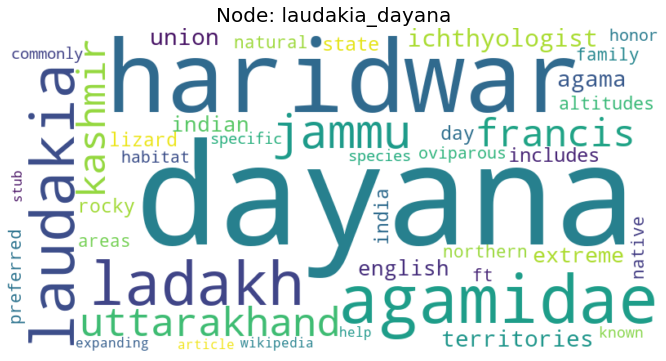

('dayana', 0.7781180739402771)
('haridwar', 0.3264921307563782)
('agamidae', 0.17940571904182434)
('ladakh', 0.14602045714855194)
('laudakia', 0.14602045714855194)
('jammu', 0.137184739112854)
('uttarakhand', 0.1349705010652542)
('francis', 0.12666435539722443)
('kashmir', 0.12536734342575073)
('ichthyologist', 0.12415406852960587)
('territories', 0.10556888580322266)
('agama', 0.1051366925239563)
('union', 0.10199619829654694)
('extreme', 0.09168355166912079)
('indian', 0.08808277547359467)
('english', 0.08808277547359467)
('includes', 0.07648512721061707)
('state', 0.07445795089006424)
('rocky', 0.07048151642084122)
('day', 0.06949358433485031)


In [ ]:
sample_name = 'laudakia_dayana'
generate_wordcloud(data_dict_reptile["top_words"][sample_name], sample_name)
# print top 20 elements in the dictionary
print_function(data_dict_reptile["top_words"][sample_name], 20)

Let us investigate another one. This time geophis_fulvoguttatus which can be seen in the snake cluster
Our hypothesis is that it also can be seen in the wordcloud and in the td-idf score

The wordcloud and the top words below indicate that there is quite a strong connection with this sample to snake, being the 3rd highest ranked. But we also see that there is not many words on the page at all, only about 15 in total

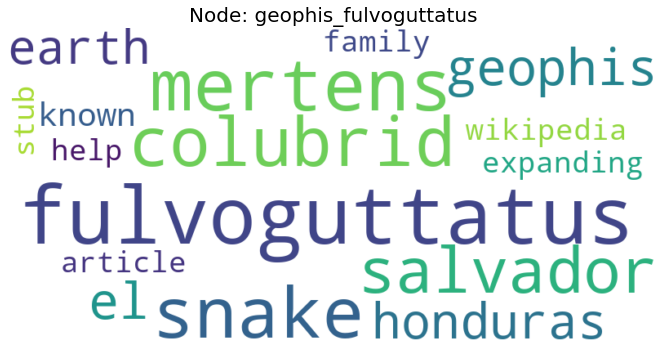

('fulvoguttatus', 0.44143447279930115)
('mertens', 0.3592900335788727)
('snake', 0.3421878516674042)
('colubrid', 0.3206845819950104)
('salvador', 0.3119744658470154)
('geophis', 0.2958552837371826)
('el', 0.2914089560508728)
('honduras', 0.2734665274620056)
('earth', 0.2560710310935974)
('known', 0.09993358701467514)
('wikipedia', 0.07793111354112625)
('stub', 0.07791164517402649)
('expanding', 0.0777173787355423)
('article', 0.07762051373720169)
('family', 0.07683277130126953)
('help', 0.07669943571090698)
('peyriéras', 0.0)
('peyrierasi', 0.0)
('peyrieras', 0.0)
('petén', 0.0)


In [ ]:
sample_name = 'geophis_fulvoguttatus'
generate_wordcloud(data_dict_reptile["top_words"][sample_name], sample_name)
print_function(data_dict_reptile["top_words"][sample_name], 20)

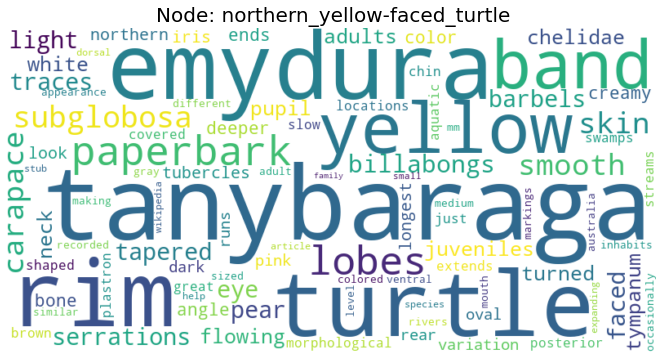

('tanybaraga', 0.2970609664916992)
('emydura', 0.24046702682971954)
('rim', 0.2356586903333664)
('turtle', 0.22902247309684753)
('yellow', 0.18834762275218964)
('band', 0.1737554669380188)
('paperbark', 0.1485304832458496)
('lobes', 0.1402541548013687)
('subglobosa', 0.1402541548013687)
('carapace', 0.13575580716133118)
('skin', 0.13497817516326904)
('smooth', 0.13236753642559052)
('billabongs', 0.12982721626758575)
('eye', 0.12304176390171051)
('tapered', 0.12295915931463242)
('traces', 0.12295915931463242)
('serrations', 0.12295915931463242)
('barbels', 0.12023351341485977)
('faced', 0.12023351341485977)
('pear', 0.1178293451666832)


In [ ]:
sample_name = "northern_yellow-faced_turtle"
generate_wordcloud(data_dict_reptile_long["top_words"][sample_name], sample_name)
print_function(data_dict_reptile_long["top_words"][sample_name], 20)

It is clear from the tf-idf scores and wordclouds above that tf-idf is a good measure if you are asked to describe what the wikiepedia page is about, and what words most accuratly describe the animal you are looking at. We also see a clear correlation between the animal and the "parent animal" having a high td-idf score, where with parent animal for i.e the northern_yellow-faced_turtle, i mean turtle. which we can see right above get the 4.th place in tf-idf ranking

### Analysis of the reptile df long (references to each other)

In [ ]:
data_dict_reptile_long["df"]

,page-name,name,links,text,family
0,/wiki/alabama_map_turtle,alabama_map_turtle,"[d%27orbigny%27s_slider, jamaican_slider, yell...",The Alabama map turtle (Graptemys pulchra) is ...,emydidae
1,/wiki/geoscincus,geoscincus,[geoscincus],Geoscincus is a monotypic genus of skinks: the...,scincidae
2,/wiki/gharial,gharial,"[chinese_alligator, cuvier%27s_dwarf_caiman, m...","The gharial (Gavialis gangeticus), also known ...",gavialidae
3,/wiki/desert_rosy_boa,desert_rosy_boa,[calabar_python],The desert rosy boa (Lichanura trivirgata) is ...,boidae
4,/wiki/oriental_garden_lizard,oriental_garden_lizard,"[bronchocela_cristatella, common_house_gecko, ...",The oriental garden lizard (Calotes versicolor...,agamidae
...,...,...,...,...,...
1058,/wiki/bothrops_jararaca,bothrops_jararaca,"[philodryas_patagoniensis, philodryas_olfersii...",Bothrops jararaca — known as the jararaca[4] o...,viperidae
1059,/wiki/dipsas_temporalis,dipsas_temporalis,[dipsas_pakaraima],"Dipsas temporalis, the temporal snail-eater, i...",colubridae
1060,/wiki/djokoiskandarus,djokoiskandarus,[djokoiskandarus],"Cantoria annulata de Jong, 1926 Djokoiskandaru...",homalopsidae
1061,/wiki/hosmer%27s_spiny-tailed_skink,hosmer%27s_spiny-tailed_skink,[cunningham%27s_spiny-tailed_skink],Hosmer's spiny-tailed skink or Hosmer's skink ...,scincidae


In [ ]:
# we want to to investigate if there is correlation between the top words and the animals family
# We will do this by seeing the if the links are in the top 20 top words

scores = []
for name, top_words in data_dict_reptile_long["top_words"].items():
    family = data_dict_reptile_long["df"][data_dict_reptile_long["df"]["name"] == name]["family"].values[0]
    
    if family in top_words:
        score = top_words[family]
    else:
        score = 0
    scores.append(score)

    
np.mean(scores)

0.05304093526015698

This is a quite bad score in general. Which makes sense, in most cases the family is only mentioned once per page, which means that it will have a quite low term frequency, while having the max or close to max inverse document frequency as we expect there atleast to be one mention of the family on a page.

## 4. Discussion. Think critically about your creation

The overall network and text analysis went well. The network shows as hypothesized that the different animal groups create communities within the network graph. The tools used on the network indicate that despite some of the worries that only the “well known” species had large enough wikipedia pages, to get a meaningful analysis, was proven wrong. As the overwhelming majority of our wikipedia pages were not “well known” species, and we still observed some beautiful clustering.


The text analysis is quite costly computationally, >30 GB ram needed to store the result in memory, which is also a contributing factor to performing the text analysis on a smaller graph. However it is possible with the help of DTU’s HPC to perform the text analysis on the large network, but this is not something that was finished before the hand in date. 
Different attributes for the nodes could also be explored, and using different splits in the network. 


As touched upon on the website, the current network graph is not entirely clean. As there are some nodes which do not belong there, but the line to draw is not straightforward. And therefore it is also not something we analyzed in the analysis. 
As noted earlier we will be looking at the links on the wikipedia page, with k = 1 depth, however one could expand this with k > 1 depth, and change the weights to show how deep you have to go in order to go from node A to node B.
